Setup the storage location for dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd gdrive/My Drive/Colab storage

/content/gdrive/My Drive/Colab storage


In [ ]:
!ls

CT_COVID  CT_NonCOVID  Data-split


Check for CUDA

In [ ]:
!nvidia-smi

Sat Oct 23 00:41:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import files
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as transforms
from skimage.util import montage
import os
import cv2 
import random
import matplotlib.pyplot as plt 
import torch.optim as optim
from PIL import Image
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from torch.utils.tensorboard import SummaryWriter
import glob
import shutil
import numpy as np
from torchvision.models import vgg19_bn
import seaborn as sns

random.seed(0)

log_dir = "~/logs"
writer = SummaryWriter(log_dir)
device = "cuda:0" if torch.cuda.is_available() else "cpu"

Visualize sample

In [ ]:
directory = '/content/gdrive/My Drive/Colab storage'

In [ ]:
!ls

'~'   CT_COVID	 CT_NonCOVID   Data-split


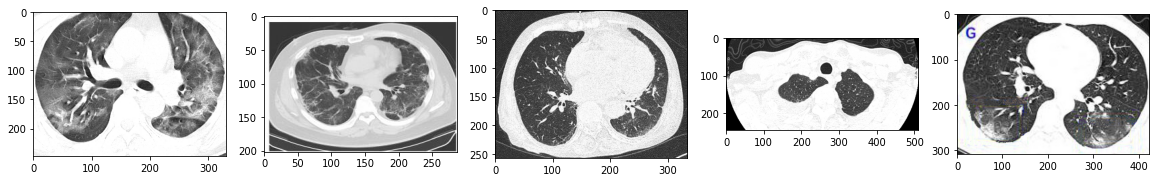

In [ ]:
covid_files_path = directory+'/CT_COVID/'
covid_files      = [os.path.join(covid_files_path, x) for x in os.listdir(covid_files_path)]
covid_images    =  [cv2.imread(x) for x in random.sample(covid_files, 5)]

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(covid_images):
    plt.subplot(len(covid_images) / columns + 1, columns, i + 1)
    plt.imshow(image)

In [ ]:
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

In [ ]:
class CovidCTDataset(Dataset):
    def __init__(self, root_dir, classes, covid_files, non_covid_files, transform=None):
        self.root_dir = root_dir
        self.classes = classes
        self.files_path = [non_covid_files, covid_files]
        self.image_list = []

        # read the files from data split text files
        covid_files = read_txt(covid_files)
        non_covid_files = read_txt(non_covid_files)

        # combine the positive and negative files into a cummulative files list
        for cls_index in range(len(self.classes)):
            
            class_files = [[os.path.join(self.root_dir, self.classes[cls_index], x), cls_index] \
                            for x in read_txt(self.files_path[cls_index])]
            self.image_list += class_files
                
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        path = self.image_list[idx][0]
        
        # Read the image
        image = Image.open(path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)

        label = int(self.image_list[idx][1])

        data = {'img':   image,
                'label': label,
                'paths' : path}

        return data

In [ ]:
normalize = transforms.Normalize(mean=[0,0,0], std=[1,1,1])
train_transformer = transforms.Compose([
    transforms.Resize(256),  
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

val_transformer = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

In [ ]:
batchsize = 8

trainset = CovidCTDataset(root_dir=directory,
                          classes = ['CT_NonCOVID', 'CT_COVID'],
                          covid_files=directory+'/Data-split/COVID/trainCT_COVID.txt',
                          non_covid_files=directory+'/Data-split/NonCOVID/trainCT_NonCOVID.txt',
                          transform= train_transformer)
valset = CovidCTDataset(root_dir=directory,
                          classes = ['CT_NonCOVID', 'CT_COVID'],
                          covid_files=directory+'/Data-split/COVID/valCT_COVID.txt',
                          non_covid_files = directory+'/Data-split/NonCOVID/valCT_NonCOVID.txt',
                          transform= val_transformer)
testset = CovidCTDataset(root_dir=directory,
                          classes = ['CT_NonCOVID', 'CT_COVID'],
                          covid_files=directory+'/Data-split/COVID/testCT_COVID.txt',
                          non_covid_files=directory+'/Data-split/NonCOVID/testCT_NonCOVID.txt',
                          transform= val_transformer)

train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)

In [ ]:
def compute_metrics(model, test_loader, plot_roc_curve = False):
    
    model.eval()
    
    val_loss = 0
    val_correct = 0
    
    criterion = nn.CrossEntropyLoss()
    
    score_list   = torch.Tensor([]).to(device)
    pred_list    = torch.Tensor([]).to(device).long()
    target_list  = torch.Tensor([]).to(device).long()
    path_list    = []

    
    for iter_num, data in enumerate(test_loader):
        
        # Convert image data into single channel data
        image, target = data['img'].to(device), data['label'].to(device)
        paths = data['paths']
        path_list.extend(paths)
        
        # Compute the loss
        with torch.no_grad():
            output = model(image)
        
        # Log loss
        val_loss += criterion(output, target.long()).item()

        
        # Calculate the number of correctly classified examples
        pred = output.argmax(dim=1, keepdim=True)
        val_correct += pred.eq(target.long().view_as(pred)).sum().item()
        
        # Bookkeeping 
        score_list   = torch.cat([score_list, nn.Softmax(dim = 1)(output)[:,1].squeeze()])
        pred_list    = torch.cat([pred_list, pred.squeeze()])
        target_list  = torch.cat([target_list, target.squeeze()])
        
    
    classification_metrics = classification_report(target_list.tolist(), pred_list.tolist(),
                                                  target_names = ['CT_NonCOVID', 'CT_COVID'],
                                                  output_dict= True)
    
    
    # sensitivity is the recall of the positive class
    sensitivity = classification_metrics['CT_COVID']['recall']
    
    # specificity is the recall of the negative class 
    specificity = classification_metrics['CT_NonCOVID']['recall']
    
    # accuracy
    accuracy = classification_metrics['accuracy']
    
    # confusion matrix
    conf_matrix = confusion_matrix(target_list.tolist(), pred_list.tolist())
    
    # roc score
    roc_score = roc_auc_score(target_list.tolist(), score_list.tolist())
    
    # plot the roc curve
    if plot_roc_curve:
        fpr, tpr, _ = roc_curve(target_list.tolist(), score_list.tolist())
        plt.plot(fpr, tpr, label = "Area under ROC = {:.4f}".format(roc_score))
        plt.legend(loc = 'best')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    
    # put together values
    metrics_dict = {"Accuracy": accuracy,
                    "Sensitivity": sensitivity,
                    "Specificity": specificity,
                    "Roc_score"  : roc_score, 
                    "Confusion Matrix": conf_matrix,
                    "Validation Loss": val_loss / len(test_loader),
                    "score_list":  score_list.tolist(),
                    "pred_list": pred_list.tolist(),
                    "target_list": target_list.tolist(),
                    "paths": path_list}
    
    
    return metrics_dict

In [ ]:
model = vgg19_bn(pretrained=True)
model.classifier[6] = nn.Linear(4096, 2)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
from collections import deque

class EarlyStopping(object):
    def __init__(self, patience = 8):
        super(EarlyStopping, self).__init__()
        self.patience = patience
        self.previous_loss = int(1e8)
        self.previous_accuracy = 0
        self.init = False
        self.accuracy_decrease_iters = 0
        self.loss_increase_iters = 0
        self.best_running_accuracy = 0
        self.best_running_loss = int(1e7)
    
    def add_data(self, model, loss, accuracy):
        
        # compute moving average
        if not self.init:
            running_loss = loss
            running_accuracy = accuracy 
            self.init = True
        
        else:
            running_loss = 0.2 * loss + 0.8 * self.previous_loss
            running_accuracy = 0.2 * accuracy + 0.8 * self.previous_accuracy
        
        # check if running accuracy has improved beyond the best running accuracy recorded so far
        if running_accuracy < self.best_running_accuracy:
            self.accuracy_decrease_iters += 1
        else:
            self.best_running_accuracy = running_accuracy
            self.accuracy_decrease_iters = 0
        
        # check if the running loss has decreased from the best running loss recorded so far
        if running_loss > self.best_running_loss:
            self.loss_increase_iters += 1
        else:
            self.best_running_loss = running_loss
            self.loss_increase_iters = 0
        
        # log the current accuracy and loss
        self.previous_accuracy = running_accuracy
        self.previous_loss = running_loss        
        
    
    def stop(self):
        
        # compute thresholds
        accuracy_threshold = self.accuracy_decrease_iters > self.patience
        loss_threshold = self.loss_increase_iters > self.patience
        
        
        # return codes corresponding to exhuaustion of patience for either accuracy or loss 
        # or both of them
        if accuracy_threshold and loss_threshold:
            return 1
        
        if accuracy_threshold:
            return 2
        
        if loss_threshold:
            return 3
        
        
        return 0
    
    def reset(self):
        # reset
        self.accuracy_decrease_iters = 0
        self.loss_increase_iters = 0
    
early_stopper = EarlyStopping(patience = 5)

In [ ]:
learning_rate = 0.01
optimizer     = optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)


In [ ]:
best_model = model
best_val_score = 0

criterion = nn.CrossEntropyLoss()

for epoch in range(60):

    model.train()    
    train_loss = 0
    train_correct = 0
    
    for iter_num, data in enumerate(train_loader):
        image, target = data['img'].to(device), data['label'].to(device)     

        # Compute the loss
        output = model(image)
        loss = criterion(output, target.long()) / 8
        
        # Log loss
        train_loss += loss.item()
        loss.backward()

        # Perform gradient udpate
        if iter_num % 8 == 0:
            optimizer.step()
            optimizer.zero_grad()
            

        # Calculate the number of correctly classified examples
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.long().view_as(pred)).sum().item()
        
    
    # Compute and print the performance metrics
    metrics_dict = compute_metrics(model, val_loader)
    print('------------------ Epoch {} Iteration {}--------------------------------------'.format(epoch,
                                                                                                 iter_num))
    print("Accuracy \t {:.3f}".format(metrics_dict['Accuracy']))
    print("Sensitivity \t {:.3f}".format(metrics_dict['Sensitivity']))
    print("Specificity \t {:.3f}".format(metrics_dict['Specificity']))
    print("Area Under ROC \t {:.3f}".format(metrics_dict['Roc_score']))
    print("Val Loss \t {}".format(metrics_dict["Validation Loss"]))
    print("------------------------------------------------------------------------------")
    
    # Save the model with best validation accuracy
    if metrics_dict['Accuracy'] > best_val_score:
        torch.save(model, "best_model.pkl")
        best_val_score = metrics_dict['Accuracy']
    
    
    # print the metrics for training data for the epoch
    print('\nTraining Performance Epoch {}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        epoch, train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
        100.0 * train_correct / len(train_loader.dataset)))
    
    # log the accuracy and losses in tensorboard
    writer.add_scalars( "Losses", {'Train loss': train_loss / len(train_loader), 'Validation_loss': metrics_dict["Validation Loss"]},
                                   epoch)
    writer.add_scalars( "Accuracies", {"Train Accuracy": 100.0 * train_correct / len(train_loader.dataset),
                                       "Valid Accuracy": 100.0 * metrics_dict["Accuracy"]}, epoch)

    # Add data to the EarlyStopper object
    early_stopper.add_data(model, metrics_dict['Validation Loss'], metrics_dict['Accuracy'])
    
    # If both accuracy and loss are not improving, stop the training
    if early_stopper.stop() == 1:
        break
    
    # if only loss is not improving, lower the learning rate
    if early_stopper.stop() == 3:
        for param_group in optimizer.param_groups:
            learning_rate *= 0.1
            param_group['lr'] = learning_rate
            print('Updating the learning rate to {}'.format(learning_rate))
            early_stopper.reset()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


------------------ Epoch 0 Iteration 53--------------------------------------
Accuracy 	 0.559
Sensitivity 	 0.483
Specificity 	 0.638
Area Under ROC 	 0.619
Val Loss 	 0.7441148976484935
------------------------------------------------------------------------------

Training Performance Epoch 0: Average loss: 0.0107, Accuracy: 260/425 (61%)

------------------ Epoch 1 Iteration 53--------------------------------------
Accuracy 	 0.636
Sensitivity 	 0.600
Specificity 	 0.672
Area Under ROC 	 0.713
Val Loss 	 0.768713936706384
------------------------------------------------------------------------------

Training Performance Epoch 1: Average loss: 0.0070, Accuracy: 335/425 (79%)

------------------ Epoch 2 Iteration 53--------------------------------------
Accuracy 	 0.788
Sensitivity 	 0.850
Specificity 	 0.724
Area Under ROC 	 0.845
Val Loss 	 0.6690062584976355
------------------------------------------------------------------------------

Training Performance Epoch 2: Average loss:

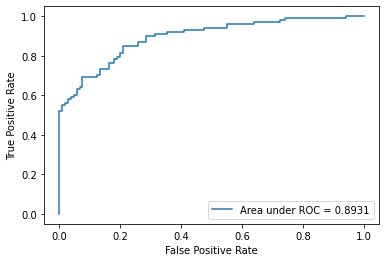

------------------- Test Performance --------------------------------------
Accuracy 	 0.808
Sensitivity 	 0.816
Specificity 	 0.800
Area Under ROC 	 0.893
------------------------------------------------------------------------------


In [ ]:
metrics_dict = compute_metrics(best_model, test_loader, plot_roc_curve = True)
print('------------------- Test Performance --------------------------------------')
print("Accuracy \t {:.3f}".format(metrics_dict['Accuracy']))
print("Sensitivity \t {:.3f}".format(metrics_dict['Sensitivity']))
print("Specificity \t {:.3f}".format(metrics_dict['Specificity']))
print("Area Under ROC \t {:.3f}".format(metrics_dict['Roc_score']))
print("------------------------------------------------------------------------------")

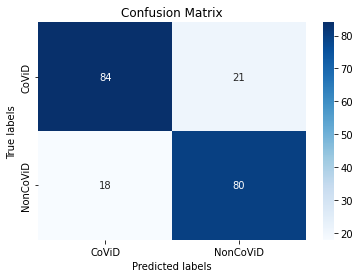

In [ ]:
conf_matrix = metrics_dict["Confusion Matrix"]
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax = ax, cmap = 'Blues'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['CoViD', 'NonCoViD']); ax.yaxis.set_ticklabels(['CoViD', 'NonCoViD']);

In [ ]:
# !git clone https://github.com/jacobgil/pytorch-grad-cam
# !mv pytorch-grad-cam gradcam

Cloning into 'pytorch-grad-cam'...
remote: Enumerating objects: 680, done.
remote: Counting objects: 100% (219/219), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 680 (delta 122), reused 149 (delta 77), pack-reused 461
Receiving objects: 100% (680/680), 1.89 MiB | 7.71 MiB/s, done.
Resolving deltas: 100% (351/351), done.


In [ ]:
# pip install gradcam/

Processing ./gradcam
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.3.2-py3-none-any.whl size=19876 sha256=16853daab54c24005a99dd4c3cd9167336138d013602796d6bd6590e7aa40be8
  Stored in directory: /tmp/pip-ephem-wheel-cache-3q0xpsed/wheels/b5/ff/1c/0131ff7cb7a36af19aa562cede823c096b283f870fdb5f625c
Successfully built grad-cam
  Attempting uninstall: grad-cam
    Found existing installation: grad-cam 1.3.2
    Uninstalling grad-cam-1.3.2:
      Successfully uninstalled grad

In [ ]:
from gradcam import *

def do_grad_cam(path):

    # Initialise the grad cam object. 
    # we use model.features as the feature extractor and use the layer no. 35 for gradients. 
    grad_cam = GradCam(model=model, feature_module=model.features, \
                           target_layer_names=["35"], use_cuda=True)

    # read in the image, and prepare it for the network
    orig_im = cv2.imread(path)
    img = Image.fromarray(orig_im)
    inp = val_transformer(img).unsqueeze(0)

    # main inference
    mask = grad_cam(inp, None)

    # create the heatmap 
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    
    #add the heatmap to the original image
    cam = heatmap + np.float32(cv2.resize(orig_im, (224,224))/255.)
    cam = cam / np.max(cam)
    
    # BGR -> RGB since OpenCV operates with BGR values. 
    cam = cam[:,:,::-1] 
    
    return cam


In [ ]:
true_positives = np.logical_and(1, 1)
# true_positives = np.logical_and(true_positives)
true_positives_indices = np.nonzero(true_positives)
true_positives_paths = [metrics_dict['paths'][i] for i in true_positives_indices[0]]

true_positive_images    =  [do_grad_cam(x) for x in random.sample(true_positives_paths, 10)]

plt.figure(figsize=(30,15))
columns = 5
for i, image in enumerate(true_positive_images):
    plt.subplot(len(true_positive_images) / columns + 1, columns, i + 1)
    plt.imshow(image)

NameError: ignored